# 2. Modelling with FD

The previous section studied how we can use the train-validate split with our own estimator to choose the best hyperparameter.  In this section, we want to investigate how FD can be used for ridge regression, while comparing to our previous approach.  We will use the same basic setup.  Hopefully, using FD doesn't change the regularisation too much - this will be a consequence of an accurate sketch.

In [43]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

In [44]:
fpath = 'datasets/'
transformed = np.load(fpath+'transformed_training_set.npy')#np.load(fpath+'train_transformed.npy')
train = np.load(fpath+'train.npy')
valid = np.load(fpath+'validate.npy')
test  = np.load(fpath+'test.npy')

X_tr   , y_tr    = transformed[:,:-1],transformed[:,-1]
X_train, y_train = train[:,:-1], train[:,-1]
X_valid, y_valid = valid[:,:-1], valid[:,-1]
X_test,  y_test   = test[:,:-1], test[:,-1]

print(f'Transformed sizes: {X_tr.shape, y_tr.shape}')
print(f'Training sizes: {X_train.shape, y_train.shape}')
print(f'Validation size: {X_valid.shape, y_valid.shape}')
print(f'Testing size: {X_test.shape, y_test.shape}')

Transformed sizes: ((16512, 16), (16512,))
Training sizes: ((13209, 16), (13209,))
Validation size: ((3303, 16), (3303,))
Testing size: ((4128, 16), (4128,))


### 3.1 More preparation: Polynomial Features
Now that we have some rough version of cross-validation working, we need to get the data ready for frequent directions.  Currently, the dimensionality is too low, so we will add polynomial features.  Our data currently has dimensionality $16$ - if we expand into a polynomial feature space of degree three this will become 
$${16 \choose 3} = 560 $$
which is much more in the realm when FD is useful.
We can also inspect the spectra to see if this decays quickly enough.

Other feature maps are also possible (e.g. random fourier features).

In [45]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

In [46]:
X_train_poly = PolynomialFeatures(degree=3).fit_transform(X_train)
X_val_poly   = PolynomialFeatures(degree=3).fit_transform(X_valid)
X_test_poly  = PolynomialFeatures(degree=3).fit_transform(X_test)

In [47]:
_, S_lin, _ = np.linalg.svd(X_train,full_matrices=False)
_, S_poly, _ = np.linalg.svd(X_train_poly,full_matrices=False)

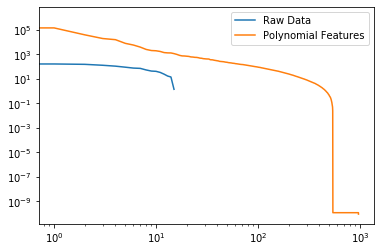

In [48]:
fig,ax = plt.subplots()
ax.plot(range(len(S_lin)), S_lin,label='Raw Data')
ax.plot(range(len(S_poly)), S_poly,label='Polynomial Features')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')

Now let's see how the cross validation behaves:

In [49]:
def ridge_loss(A,x,y,gamma):
    return (0.5*np.linalg.norm(A@x - y)**2 + 0.5*gamma*np.linalg.norm(x))/len(A)

In [50]:
import scipy.sparse as sp
from scipy import linalg
from scipy import sparse
from scipy.sparse import linalg as sp_linalg

class RidgeRegression:
    def __init__(self,gamma):
        self.gamma = gamma
    
    def _solve_svd(self, X, y, alpha):
        U, s, Vt = linalg.svd(X, full_matrices=False)
        idx = s > 1e-15  # same default value as scipy.linalg.pinv
        s_nnz = s[idx][:, np.newaxis]
        UTy = np.dot(U.T, y)[:,np.newaxis]
        d = np.zeros((s.size, alpha.size), dtype=X.dtype)
        d[idx] = s_nnz / (s_nnz ** 2 + alpha)
        d_UT_y = np.squeeze(d * UTy) # squeeze to a single dimension
        sol = Vt.T@d_UT_y
        return sol#np.dot(Vt.T, d_UT_y)
    
    def _ridge_solve(self, X,y,alpha):
        # There should be either 1 or n_targets penalties
        alpha = np.asarray(alpha, dtype=X.dtype).ravel()
        assert alpha.size == 1
        return self._solve_svd(X,y,alpha)
        
    def _preprocess_data(self,X, y, fit_intercept, normalize=False):
        """Center and scale data.
        Centers data to have mean zero along axis 0. 
        If fit_intercept=False or if
        the X is a sparse matrix, no centering is done, but normalization can still
        be applied. The function returns the statistics necessary to reconstruct
        the input data, which are X_offset, y_offset, X_scale, such that the output
            X = (X - X_offset) / X_scale
        X_scale is the L2 norm of X - X_offset. 
        This is here because nearly all linear models will want their data to be
        centered. This function also systematically makes y consistent with X.dtype
        """
        n,d = X.shape
        self.n_targets = d
        y = np.asarray(y, dtype=X.dtype)
        if fit_intercept:
            X_offset = np.mean(X,axis=0)
            X -= X_offset
            if normalize:
                X_scale = np.linalg.norm(X,axis=0)
            else:
                X_scale = np.ones(X.shape[1], dtype=X.dtype)
            y_offset = np.mean(y,axis=0)
            y = y - y_offset
        else:
            # Return zero arrays for the offsets and ones for the scales
            X_offset = np.zeros(X.shape[1],dtype=X.dtype)
            X_scale = np.ones_like(X_offset)
            if y.ndim == 1:
                y_offset = X.dtype.type(0)
            else:
                y_offset = np.zeros(y.shape[1],dtype=X.dtype)
        return X,y, X_offset, y_offset, X_scale
    
    def _set_intercept(self, X_offset, y_offset, X_scale):
        '''
        Sets the intercept of the model
        '''
        self.coef_ = self.coef_ / X_scale
        self.intercept_ = y_offset - X_offset@self.coef_
    
        
    def fit(self,A,y):
        '''
        Fits the ridge model to gamma (which can be a single float or list/ndarray).
        '''
        n,d = A.shape
        # Centering the arrays for consistency with sklearn.
        X,y,X_offset, y_offset, X_scale = self._preprocess_data(A,y,fit_intercept=True)
        weights = self._ridge_solve(X,y,self.gamma)
        self.coef_ = weights
        self._set_intercept(X_offset, y_offset, X_scale)

    def predict(self,X,weights):
        return X@weights + self.intercept_
    
    def error(self, y_pred, y_true):
        return (1./np.sqrt(len(y_pred)))*np.linalg.norm(y_pred - y_true)
        

In [51]:
gammas = [0] + [2**i for i in range(-15,15)]
poly_training_errors = np.zeros(len(gammas),dtype=float)
poly_validation_errors = np.zeros_like(poly_training_errors)
poly_test_errors = np.zeros_like(poly_training_errors)
for i,gi in enumerate(gammas):
    pridge = RidgeRegression(gi)
    pridge.fit(X_train_poly,y_train)
    y_train_pred = pridge.predict(X_train_poly,pridge.coef_)
    train_error = pridge.error(y_train_pred, y_train)
    y_train_val = pridge.predict(X_val_poly,pridge.coef_)
    val_error = pridge.error(y_train_val, y_valid)
    print(f'Gamma:{gi:.3E}\t\tTrainError:{train_error:.5E}\t\tValiError:{val_error:.5E}')
    poly_training_errors[i] = train_error
    poly_validation_errors[i] = val_error
#plt.plot(gammas,training_errors)

Gamma:0.000E+00		TrainError:8.31051E+06		ValiError:3.14353E-02
Gamma:3.052E-05		TrainError:1.88577E-03		ValiError:5.45246E-02
Gamma:6.104E-05		TrainError:1.88578E-03		ValiError:5.43035E-02
Gamma:1.221E-04		TrainError:1.88579E-03		ValiError:5.38791E-02
Gamma:2.441E-04		TrainError:1.88585E-03		ValiError:5.30900E-02
Gamma:4.883E-04		TrainError:1.88599E-03		ValiError:5.16933E-02
Gamma:9.766E-04		TrainError:1.88630E-03		ValiError:4.93971E-02
Gamma:1.953E-03		TrainError:1.88687E-03		ValiError:4.60360E-02
Gamma:3.906E-03		TrainError:1.88785E-03		ValiError:4.19318E-02
Gamma:7.812E-03		TrainError:1.88942E-03		ValiError:3.80133E-02
Gamma:1.562E-02		TrainError:1.89167E-03		ValiError:3.51250E-02
Gamma:3.125E-02		TrainError:1.89462E-03		ValiError:3.33003E-02
Gamma:6.250E-02		TrainError:1.89826E-03		ValiError:3.19875E-02
Gamma:1.250E-01		TrainError:1.90250E-03		ValiError:3.06335E-02
Gamma:2.500E-01		TrainError:1.90720E-03		ValiError:2.90338E-02
Gamma:5.000E-01		TrainError:1.91239E-03		ValiError:2.73

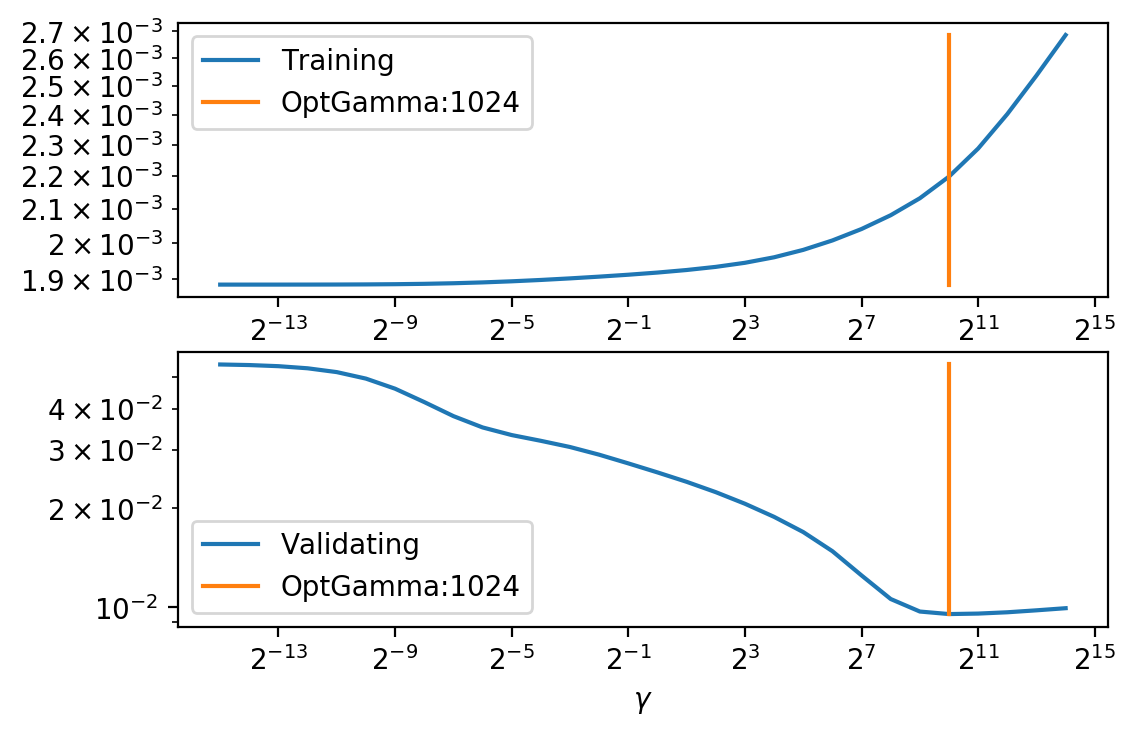

In [52]:
# Optimal regularisation:
opt_gamma = gammas[np.argmin(poly_validation_errors[1:])+1]

fig, axes = plt.subplots(nrows=2,dpi=200)
ax_t, ax_v = axes
ax_t.plot(gammas[1:],poly_training_errors[1:],label='Training')
#ax_t.plot([opt_gamma,opt_gamma],[training_errors[1:].min(),training_errors[1:].max()],label=f'OptGamma:{opt_gamma}')
ax_v.plot(gammas[1:],poly_validation_errors[1:],label='Validating')

for ax in [ax_t,ax_v]:
    if ax == ax_t:
        val_min, val_max = poly_training_errors[1:].min(),poly_training_errors[1:].max()
    else:
        val_min, val_max = poly_validation_errors[1:].min(),poly_validation_errors[1:].max()
    ax.plot([opt_gamma,opt_gamma],[val_min, val_max],label=f'OptGamma:{opt_gamma}')
    ax.set_yscale('log')
    ax.set_xscale('log',basex=2)
    ax.set_xlabel(r'$\gamma$')
    ax.legend()

The above plot seems to make sense: since we have expanded the feature space, we are more prone to overfitting and a way to remedy this is to regularise more.

### 3.2 Frequent Directions for Regression

Now that we have an interface that roughly corresponds with sklearn we can begin to start testing FD for model fitting.  This approach needs to roughly correspond with the class that I have already written so should have the following methods:
- Solve
- preprocess (a question here is whether we process on the raw data or on the sketch?)
- fit
- predict
- intercept
- error

The `fit` method is just going to be a wrapper around the internal workings of `preprocess, set_intercept, preprocess` so it's important to think about how all of this is going to interact.

The other thing to be aware of is that DataSketches only has implemented the [sketching technique](https://github.com/apache/incubator-datasketches-vector/blob/32c1443774472bb7382b7d88fc22d044c8808dc3/src/main/java/org/apache/datasketches/vector/decomposition/FrequentDirections.java#L348) and no further functionality for regression.

In light of this, we will import the sketches under the assumption that there is a good implementation of the sketch
algorithm itself, i.e. we can just call $B = FD(A)$ for some input $A$ to get the sketch $B$.

I will write this so it roughly follows what I already have, along with some extra methods where necessary.

In [67]:
import sys
import os
from pathlib import Path

In [59]:
path = Path(os.getcwd())
sys.path.append(str(path.parent.parent/ 'src/frequent_directions.py'))

PosixPath('/Users/charlied/Google Drive/FrequentDirectionsRidgeRegression/notebooks/CaliforniaHousing')

In [69]:
from frequent_directions import FastFrequentDirections,RobustFrequentDirections

In [153]:
#RobustFrequentDirections??

In [132]:
class FDRidge:
    
    def __init__(self, fd_dim:int,fd_mode='FD',gamma=1.0,solve_method='Exact'):
        """
        Approximate ridge regression using the FD sketch.

        fd_dim (int) - the number of rows retained in the FD sketch.
        fd_mode (str) : mode for frequent directions FD or RFD.
        alpha : float - the regularisation parameter for ridge regression.
        """
        self.fd_dim       = fd_dim
        self.fd_mode      = fd_mode
        if self.fd_mode not in ['FD', 'RFD']:
            raise NotImplementedError('Only F(ast) and R(obust) FD methods are supported.')
        self.gamma        = gamma
        self.solve_method = solve_method
        if self.solve_method not in ['Exact','Shi', 'Woodbury']:
            raise NotImplementedError('Only Exact, Shi, Woodbury methods are implemented')
        self.is_fitted    = False
        
    def _sketch(self,X):
        if self.fd_mode == 'FD':
            sketcher = FastFrequentDirections(X.shape[1],m=self.fd_dim)
        elif self.fd_mode == 'RFD':
            sketcher = RobustFrequentDirections(X.shape[1],m=self.fd_dim)
        sketcher.fit(X,batch_size=self.fd_dim)
        self.sketch_mat = sketcher.sketch
        self.alpha = sketcher.delta # == 0 if using FastFrequentDirections so can use self.gamma + self.alpha everywhere 
        self.is_fitted = True
        
    def get_sketch_bytes(self):
        return self.sketch_mat.nbytes
    
    def get_sketch_size(self):
        return self.sketch_mat.shape
        
    def my_small_space_solve(self,X,y):
        '''
        Uses Woodbury to instead of evaluating $B^T B + gamma I)^{-1}
        '''
        self._sketch(X)
        B = self.sketch_mat
        BATy = B@(X.T@y)
        inv_term = np.linalg.pinv(np.eye(self.fd_dim) + B@B.T)
        right_term = inv_term@BATy
        full_inv_term = (1./self.gamma)*(X.T@y) - (B.T/self.gamma)@right_term
        return full_inv_term
    
    def shi_small_space_solve(self,X,y):
        '''
        Solves in small space using the algorithm of shi and phillips
        '''
        ATy = X.T@y
        self._sketch(X)
        B = self.sketch_mat
        _, S, Vt = np.linalg.svd(B,full_matrices=False)
        V = Vt.T
        inv_diag = np.linalg.pinv(np.diag(S**2 + self.gamma)) #1./(S**2 + self.gamma)
        first_term = (V@(inv_diag))@(Vt@ATy)
        second_term = (1./self.gamma)*ATy
        third_term = (1./self.gamma)*V@(Vt@ATy)
        return first_term + second_term - third_term
        
        
    def _solve(self, X, y):
        '''
        Obtains the inverse term explicitly
        '''
        if self.solve_method == 'Shi':
            return self.shi_small_space_solve(X,y)
        elif self.solve_method == 'Woodbury':
            return self.my_small_space_solve(X,y)
        else:
            self._sketch(X)
            return (np.linalg.pinv(self.sketch_mat.T@self.sketch_mat + self.gamma*np.eye(X.shape[1])))@(X.T@y)
        
        
    def _preprocess_data(self,X, y, fit_intercept, normalize=False):
        """Center and scale data.
        Centers data to have mean zero along axis 0. 
        If fit_intercept=False or if
        the X is a sparse matrix, no centering is done, but normalization can still
        be applied. The function returns the statistics necessary to reconstruct
        the input data, which are X_offset, y_offset, X_scale, such that the output
            X = (X - X_offset) / X_scale
        X_scale is the L2 norm of X - X_offset. 
        This is here because nearly all linear models will want their data to be
        centered. This function also systematically makes y consistent with X.dtype
        """
        n,d = X.shape
        self.n_targets = d
        y = np.asarray(y, dtype=X.dtype)
        if fit_intercept:
            X_offset = np.mean(X,axis=0)
            X -= X_offset
            if normalize:
                X_scale = np.linalg.norm(X,axis=0)
            else:
                X_scale = np.ones(X.shape[1], dtype=X.dtype)
            y_offset = np.mean(y,axis=0)
            y = y - y_offset
        else:
            # Return zero arrays for the offsets and ones for the scales
            X_offset = np.zeros(X.shape[1],dtype=X.dtype)
            X_scale = np.ones_like(X_offset)
            if y.ndim == 1:
                y_offset = X.dtype.type(0)
            else:
                y_offset = np.zeros(y.shape[1],dtype=X.dtype)
        return X,y, X_offset, y_offset, X_scale
    
    def _set_intercept(self, X_offset, y_offset, X_scale):
        '''
        Sets the intercept of the model
        '''
        self.coef_ = self.coef_ / X_scale
        self.intercept_ = y_offset - X_offset@self.coef_
    
        
    def fit(self,A,y):
        '''
        Fits the ridge model to gamma (which can be a single float or list/ndarray).
        '''
        n,d = A.shape
        # Centering the arrays for consistency with sklearn.
        X,y,X_offset, y_offset, X_scale = self._preprocess_data(A,y,fit_intercept=True)
        weights = self._solve(X,y)
        self.coef_ = weights
        self._set_intercept(X_offset, y_offset, X_scale)

    def predict(self,X,weights):
        return X@weights + self.intercept_
    
    def error(self, y_pred, y_true):
        return (1./np.sqrt(len(y_pred)))*np.linalg.norm(y_pred - y_true)

First, let's establish that there is reasonable accuracy from the regression task using FD.

In [123]:
fd_ridge = FDRidge(fd_dim=256,fd_mode='RFD',gamma=256.)
fd_ridge.fit(X_train_poly,y_train)

ridge = RidgeRegression(256.)
ridge.fit(X_train_poly,y_train)

In [124]:
fd_error = np.linalg.norm(ridge.coef_ - fd_ridge.coef_)
print(f'FD Regression sketching error: {fd_error:.6f}')

FD Regression sketching error: 0.001990


(-0.0025, 0.0025)

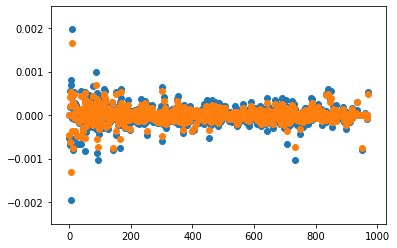

In [125]:
fig, ax = plt.subplots()
ax.scatter(range(len(fd_ridge.coef_)),fd_ridge.coef_,label='FD')
ax.scatter(range(len(ridge.coef_)),ridge.coef_,label='Exact')
ax.set_ylim(-0.0025,0.0025)

One thing to consider here is that because of the shrinkage applied to the spectrum, the directions in FDRR need boosting slightly.  This is achieved by using a slightly larger regularisation parameter $\gamma$.

### 3.3 Different methods for solving

There are different solutions that can be returned.  We have the standard solution:
\begin{align}
\text{[Standard]} \quad x_S &= (B^T B + \gamma I)^{-1} X^T y \\ 
\text{[Woodbury]} \quad x_W &= \frac1\gamma \left[I_d - \frac{B^T}{\gamma}(I_m + BB^T)^{-1}B \right] X^T y \\
\text{[EigenVec]} \quad x_E &= \left[V(\Sigma^2 +\gamma I_m)^{-1}V^T + \frac1\gamma (I_d - VV^T)  \right]X^T y \\
\end{align}

Eigenvec and Woodbury are the same up to determining whether to use the basis or the sketch itself.  This can be shown by using the SVD of $B = U \Sigma V^T$ and decomposing the entire product to show equivalence.  Let's plot the performance of the FD methods vs the exact method.

In [126]:
# Solve using FD - Exact solver

gammas = [0] + [2**i for i in range(-15,15)]
fd_poly_training_errors = np.zeros(len(gammas),dtype=float)
sketch_nbytes = np.zeros_like(fd_poly_training_errors)
fd_poly_validation_errors = np.zeros_like(fd_poly_training_errors)
fd_poly_test_errors = np.zeros_like(fd_poly_training_errors)
for i,gi in enumerate(gammas):
    fd_ridge = FDRidge(fd_dim=256,fd_mode='RFD',gamma=gi)
    fd_ridge.fit(X_train_poly,y_train)
    y_train_pred = fd_ridge.predict(X_train_poly,fd_ridge.coef_)
    train_error = fd_ridge.error(y_train_pred, y_train)
    y_train_val = fd_ridge.predict(X_val_poly,fd_ridge.coef_)
    val_error = fd_ridge.error(y_train_val, y_valid)
    print(f'Gamma:{gi:.3E}\t\tTrainError:{train_error:.5E}\t\tValiError:{val_error:.5E}')
    fd_poly_training_errors[i] = train_error
    fd_poly_validation_errors[i] = val_error
    sketch_nbytes[i] = fd_ridge.get_sketch_bytes()

Gamma:0.000E+00		TrainError:5.60652E-02		ValiError:6.73956E-01
Gamma:3.052E-05		TrainError:5.60551E-02		ValiError:6.73872E-01
Gamma:6.104E-05		TrainError:5.60456E-02		ValiError:6.73785E-01
Gamma:1.221E-04		TrainError:5.60351E-02		ValiError:6.73690E-01
Gamma:2.441E-04		TrainError:5.60081E-02		ValiError:6.73452E-01
Gamma:4.883E-04		TrainError:5.59548E-02		ValiError:6.72969E-01
Gamma:9.766E-04		TrainError:5.58511E-02		ValiError:6.72059E-01
Gamma:1.953E-03		TrainError:3.77902E+01		ValiError:4.23283E+02
Gamma:3.906E-03		TrainError:1.89184E+01		ValiError:2.11615E+02
Gamma:7.812E-03		TrainError:9.45353E+00		ValiError:1.06000E+02
Gamma:1.562E-02		TrainError:4.72513E+00		ValiError:5.31422E+01
Gamma:3.125E-02		TrainError:2.36393E+00		ValiError:2.67086E+01
Gamma:6.250E-02		TrainError:1.18331E+00		ValiError:1.34871E+01
Gamma:1.250E-01		TrainError:5.93026E-01		ValiError:6.86870E+00
Gamma:2.500E-01		TrainError:2.97699E-01		ValiError:3.54705E+00
Gamma:5.000E-01		TrainError:1.49662E-01		ValiError:1.87

In [128]:
print(f'Input array size: {X_train.shape} bytes: {X_train.nbytes}')
print(f'Sketch rows: 256; bytes: {sketch_nbytes}')

Input array size: (13209, 16) bytes: 1690752
Sketch rows: 256; bytes: [1984512. 1984512. 1984512. 1984512. 1984512. 1984512. 1984512. 1984512.
 1984512. 1984512. 1984512. 1984512. 1984512. 1984512. 1984512. 1984512.
 1984512. 1984512. 1984512. 1984512. 1984512. 1984512. 1984512. 1984512.
 1984512. 1984512. 1984512. 1984512. 1984512. 1984512. 1984512.]


In [135]:
fd_ridge = FDRidge(fd_dim=256,fd_mode='RFD',gamma=gi)
fd_ridge.fit(X_train_poly,y_train)
print(fd_ridge.get_sketch_bytes(), fd_ridge.get_sketch_size())

1984512 (256, 969)


In [144]:
print('Using FD results in a {:.1f}x factor space saving in rows and bytes'.format(X_train_poly.shape[0] / fd_ridge.get_sketch_size()[0] / fd_ridge.get_sketch_size()[0]))

Using FD results in a 51.6x factor space saving in rows and bytes


This is equivalent to saying that the summary is 2% the size of the input data, and provided that the hyperparameter is appropriately set, yields equivalent validation performance.

In [150]:
print(f'Input rows:{X_train_poly.shape[0]}\t0.02 x input rows:{fd_ridge.get_sketch_size()[0]}')

Input rows:13209	0.02 x input rows:256


Optimal gamma: 1024
FD Optimal gamma: 1024


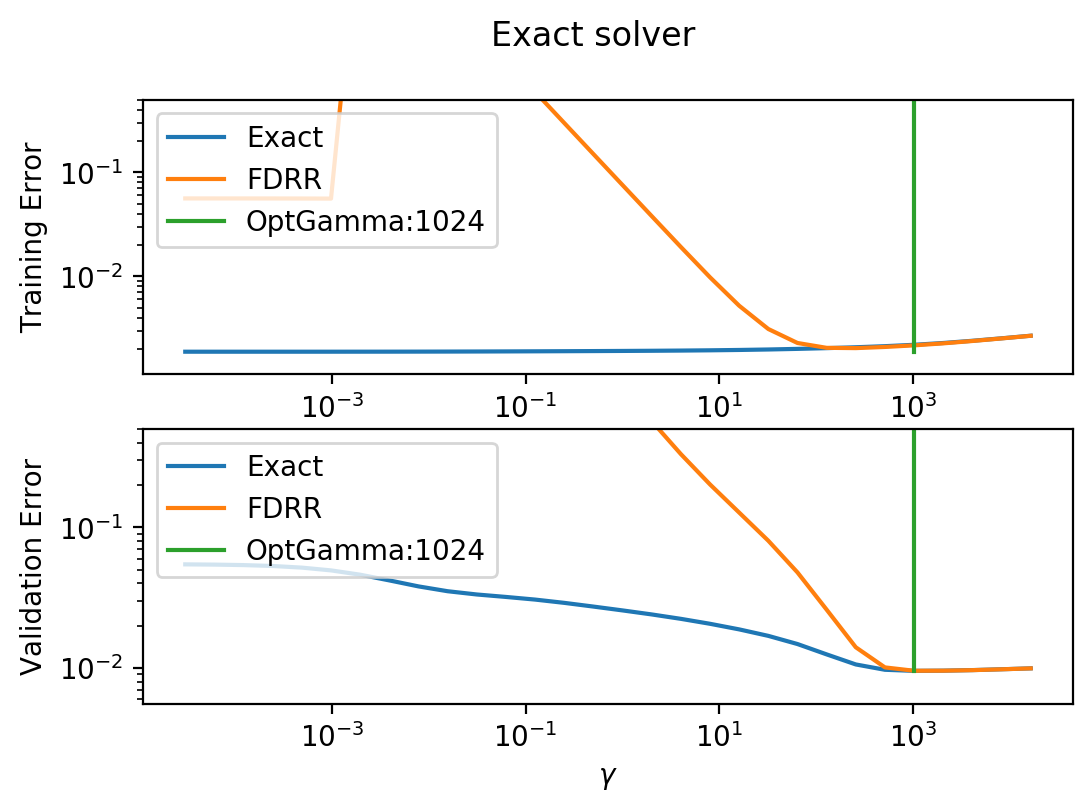

In [154]:
# Optimal regularisation:
opt_gamma = gammas[np.argmin(poly_validation_errors[1:])+1]
opt_fd_gamma = gammas[np.argmin(fd_poly_validation_errors[1:])+1]

fig, axes = plt.subplots(nrows=2,dpi=200)
ax_t, ax_v = axes
ax_t.plot(gammas[1:],poly_training_errors[1:],label='Exact')
ax_t.plot(gammas[1:],fd_poly_training_errors[1:],label='FDRR')
ax_t.set_ylabel('Training Error')

#ax_t.plot([opt_gamma,opt_gamma],[training_errors[1:].min(),training_errors[1:].max()],label=f'OptGamma:{opt_gamma}')
ax_v.plot(gammas[1:],poly_validation_errors[1:],label='Exact')
ax_v.plot(gammas[1:],fd_poly_validation_errors[1:],label='FDRR')
ax_v.set_ylabel('Validation Error')

for ax in [ax_t,ax_v]:
    if ax == ax_t:
        val_min, val_max = poly_training_errors[1:].min(),fd_poly_training_errors[1:].max()
    else:
        val_min, val_max = poly_validation_errors[1:].min(),fd_poly_validation_errors[1:].max()
    ax.plot([opt_gamma,opt_gamma],[val_min, val_max],label=f'OptGamma:{opt_gamma}')
    ax.set_yscale('log')
    ax.set_yscale('log',basey=10)
    ax.set_xscale('log',basex=10)
    ax.set_xlabel(r'$\gamma$')
    ax.legend(loc='upper left')
    ax.set_ylim(top=2**(-1))
fig.suptitle('Exact solver')
print(f'Optimal gamma: {opt_gamma}')
print(f'FD Optimal gamma: {opt_fd_gamma}')


This is only the behaviour for the exact solver, i.e. $x_S.  We can repeat the same process for Woodbury and Eigenvector $ x_W, x_E$.

In [156]:
# Solve using FD - Using Woodbury solver

gammas = [2**i for i in range(-15,15)]
fd_poly_training_errors = np.zeros(len(gammas),dtype=float)
sketch_nbytes = np.zeros_like(fd_poly_training_errors)
fd_poly_validation_errors = np.zeros_like(fd_poly_training_errors)
fd_poly_test_errors = np.zeros_like(fd_poly_training_errors)
for i,gi in enumerate(gammas):
    fd_ridge = FDRidge(fd_dim=256,fd_mode='RFD',gamma=gi,solve_method='Woodbury')
    fd_ridge.fit(X_train_poly,y_train)
    y_train_pred = fd_ridge.predict(X_train_poly,fd_ridge.coef_)
    train_error = fd_ridge.error(y_train_pred, y_train)
    y_train_val = fd_ridge.predict(X_val_poly,fd_ridge.coef_)
    val_error = fd_ridge.error(y_train_val, y_valid)
    print(f'Gamma:{gi:.3E}\t\tTrainError:{train_error:.5E}\t\tValiError:{val_error:.5E}')
    fd_poly_training_errors[i] = train_error
    fd_poly_validation_errors[i] = val_error
    sketch_nbytes[i] = fd_ridge.get_sketch_bytes()

Gamma:3.052E-05		TrainError:2.49143E+03		ValiError:3.32460E+04
Gamma:6.104E-05		TrainError:1.24571E+03		ValiError:1.66230E+04
Gamma:1.221E-04		TrainError:6.22856E+02		ValiError:8.31150E+03
Gamma:2.441E-04		TrainError:3.11428E+02		ValiError:4.15575E+03
Gamma:4.883E-04		TrainError:1.55713E+02		ValiError:2.07787E+03
Gamma:9.766E-04		TrainError:7.78563E+01		ValiError:1.03894E+03
Gamma:1.953E-03		TrainError:3.89277E+01		ValiError:5.19468E+02
Gamma:3.906E-03		TrainError:1.94634E+01		ValiError:2.59734E+02
Gamma:7.812E-03		TrainError:9.73129E+00		ValiError:1.29867E+02
Gamma:1.562E-02		TrainError:4.86522E+00		ValiError:6.49332E+01
Gamma:3.125E-02		TrainError:2.43219E+00		ValiError:3.24665E+01
Gamma:6.250E-02		TrainError:1.21567E+00		ValiError:1.62331E+01
Gamma:1.250E-01		TrainError:6.07421E-01		ValiError:8.11637E+00
Gamma:2.500E-01		TrainError:3.03306E-01		ValiError:4.05803E+00
Gamma:5.000E-01		TrainError:1.51270E-01		ValiError:2.02887E+00
Gamma:1.000E+00		TrainError:7.52957E-02		ValiError:1.01

Optimal gamma: 2048
FD Optimal gamma: 4096


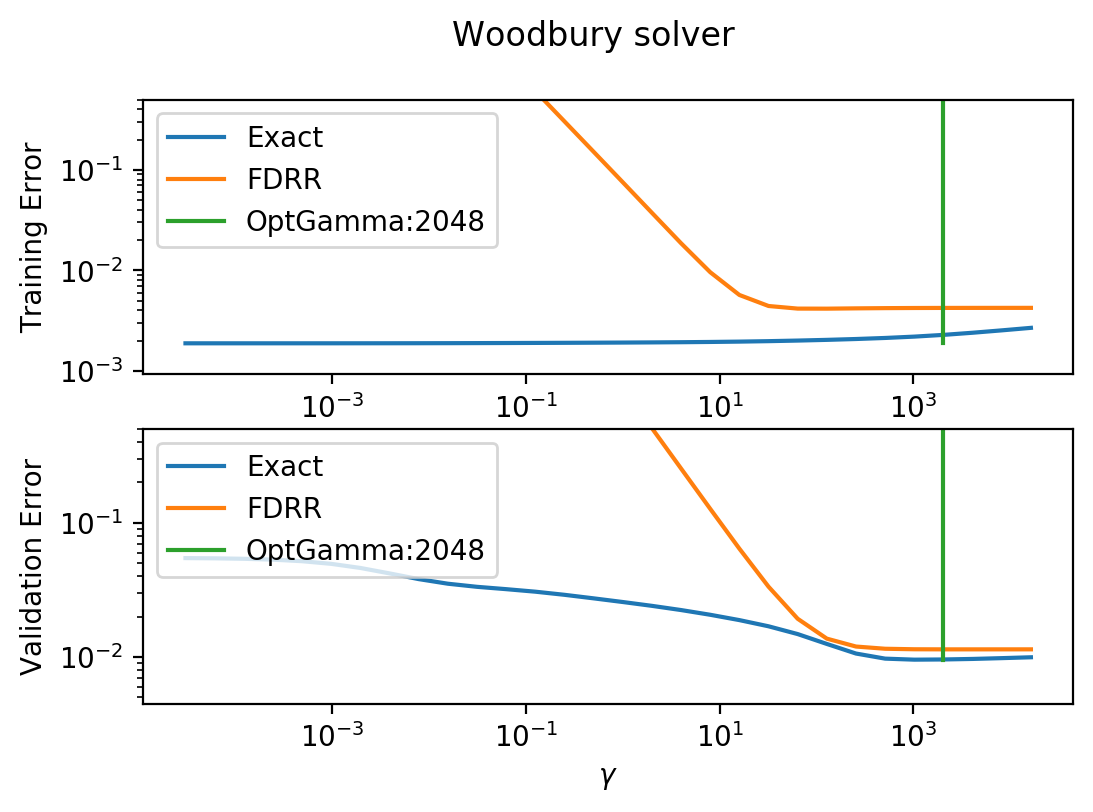

In [161]:
# Optimal regularisation:
opt_gamma = gammas[np.argmin(poly_validation_errors[1:])+1]
opt_fd_gamma = gammas[np.argmin(fd_poly_validation_errors[1:])+1]

fig, axes = plt.subplots(nrows=2,dpi=200)
ax_t, ax_v = axes
ax_t.plot(gammas[:],poly_training_errors[1:],label='Exact')
ax_t.plot(gammas[:],fd_poly_training_errors[:],label='FDRR')
ax_t.set_ylabel('Training Error')

#ax_t.plot([opt_gamma,opt_gamma],[training_errors[1:].min(),training_errors[1:].max()],label=f'OptGamma:{opt_gamma}')
ax_v.plot(gammas[:],poly_validation_errors[1:],label='Exact')
ax_v.plot(gammas[:],fd_poly_validation_errors[:],label='FDRR')
ax_v.set_ylabel('Validation Error')

for ax in [ax_t,ax_v]:
    if ax == ax_t:
        val_min, val_max = poly_training_errors[1:].min(),fd_poly_training_errors[1:].max()
    else:
        val_min, val_max = poly_validation_errors[1:].min(),fd_poly_validation_errors[1:].max()
    ax.plot([opt_gamma,opt_gamma],[val_min, val_max],label=f'OptGamma:{opt_gamma}')
    ax.set_yscale('log')
    ax.set_yscale('log',basey=10)
    ax.set_xscale('log',basex=10)
    ax.set_xlabel(r'$\gamma$')
    ax.legend(loc='upper left')
    ax.set_ylim(top=2**(-1))
fig.suptitle('Woodbury solver')
print(f'Optimal gamma: {opt_gamma}')
print(f'FD Optimal gamma: {opt_fd_gamma}')


In [162]:
# Solve using FD - Using Shi Phillips

gammas = [2**i for i in range(-15,15)]
fd_poly_training_errors = np.zeros(len(gammas),dtype=float)
sketch_nbytes = np.zeros_like(fd_poly_training_errors)
fd_poly_validation_errors = np.zeros_like(fd_poly_training_errors)
fd_poly_test_errors = np.zeros_like(fd_poly_training_errors)
for i,gi in enumerate(gammas):
    fd_ridge = FDRidge(fd_dim=256,fd_mode='RFD',gamma=gi,solve_method='Shi')
    fd_ridge.fit(X_train_poly,y_train)
    y_train_pred = fd_ridge.predict(X_train_poly,fd_ridge.coef_)
    train_error = fd_ridge.error(y_train_pred, y_train)
    y_train_val = fd_ridge.predict(X_val_poly,fd_ridge.coef_)
    val_error = fd_ridge.error(y_train_val, y_valid)
    print(f'Gamma:{gi:.3E}\t\tTrainError:{train_error:.5E}\t\tValiError:{val_error:.5E}')
    fd_poly_training_errors[i] = train_error
    fd_poly_validation_errors[i] = val_error
    sketch_nbytes[i] = fd_ridge.get_sketch_bytes()

Gamma:3.052E-05		TrainError:2.41808E+03		ValiError:2.70677E+04
Gamma:6.104E-05		TrainError:1.20904E+03		ValiError:1.35340E+04
Gamma:1.221E-04		TrainError:6.04522E+02		ValiError:6.76714E+03
Gamma:2.441E-04		TrainError:3.02262E+02		ValiError:3.38371E+03
Gamma:4.883E-04		TrainError:1.51132E+02		ValiError:1.69200E+03
Gamma:9.766E-04		TrainError:7.55671E+01		ValiError:8.46139E+02
Gamma:1.953E-03		TrainError:3.77846E+01		ValiError:4.23210E+02
Gamma:3.906E-03		TrainError:1.88934E+01		ValiError:2.11745E+02
Gamma:7.812E-03		TrainError:9.44784E+00		ValiError:1.06012E+02
Gamma:1.562E-02		TrainError:4.72511E+00		ValiError:5.31450E+01
Gamma:3.125E-02		TrainError:2.36384E+00		ValiError:2.67091E+01
Gamma:6.250E-02		TrainError:1.18330E+00		ValiError:1.34870E+01
Gamma:1.250E-01		TrainError:5.93029E-01		ValiError:6.86839E+00
Gamma:2.500E-01		TrainError:2.97697E-01		ValiError:3.54702E+00
Gamma:5.000E-01		TrainError:1.49661E-01		ValiError:1.87042E+00
Gamma:1.000E+00		TrainError:7.52957E-02		ValiError:1.01

Optimal gamma: 2048
FD Optimal gamma: 1024


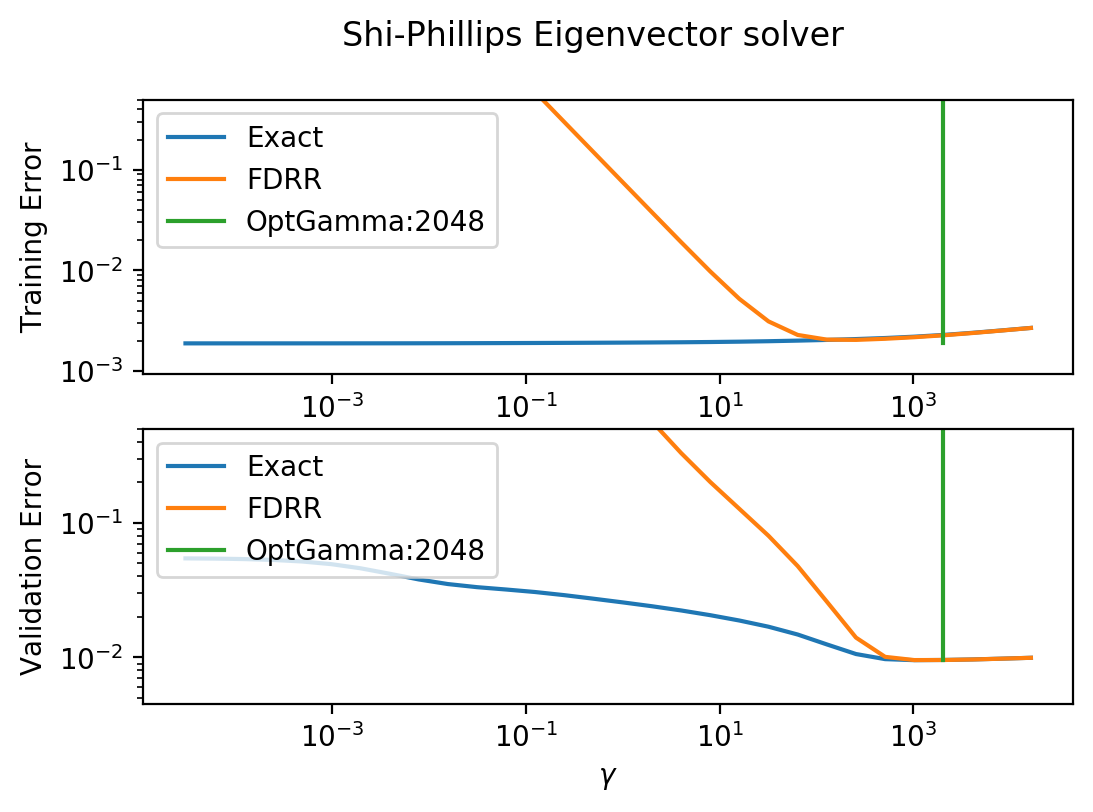

In [163]:
# Optimal regularisation:
opt_gamma = gammas[np.argmin(poly_validation_errors[1:])+1]
opt_fd_gamma = gammas[np.argmin(fd_poly_validation_errors[1:])+1]

fig, axes = plt.subplots(nrows=2,dpi=200)
ax_t, ax_v = axes
ax_t.plot(gammas[:],poly_training_errors[1:],label='Exact')
ax_t.plot(gammas[:],fd_poly_training_errors[:],label='FDRR')
ax_t.set_ylabel('Training Error')

#ax_t.plot([opt_gamma,opt_gamma],[training_errors[1:].min(),training_errors[1:].max()],label=f'OptGamma:{opt_gamma}')
ax_v.plot(gammas[:],poly_validation_errors[1:],label='Exact')
ax_v.plot(gammas[:],fd_poly_validation_errors[:],label='FDRR')
ax_v.set_ylabel('Validation Error')

for ax in [ax_t,ax_v]:
    if ax == ax_t:
        val_min, val_max = poly_training_errors[1:].min(),fd_poly_training_errors[1:].max()
    else:
        val_min, val_max = poly_validation_errors[1:].min(),fd_poly_validation_errors[1:].max()
    ax.plot([opt_gamma,opt_gamma],[val_min, val_max],label=f'OptGamma:{opt_gamma}')
    ax.set_yscale('log')
    ax.set_yscale('log',basey=10)
    ax.set_xscale('log',basex=10)
    ax.set_xlabel(r'$\gamma$')
    ax.legend(loc='upper left')
    ax.set_ylim(top=2**(-1))
fig.suptitle('Shi-Phillips Eigenvector solver')
print(f'Optimal gamma: {opt_gamma}')
print(f'FD Optimal gamma: {opt_fd_gamma}')

**Summary**:
The three methods all perform similarly.  However, the main point is that it looks like the Shi-Phillips approach is slightly more numerically stable than using Woodbury explicitly.  Probably, if more care is taken with the Woodbury implementation this can be improved.
As expected, they are both roughly similar to the exact method (which is not scalable for large $d$).

### 3.4 Understanding how regularization helps
Performance is better when $\gamma$ is increased, but why is this the case?  Hopefully the plot below should give some information as to why this is the case.  The figure shows that adding the regularization boosts all of the singular values, but the relative difference between the largest and the smallest singular values is reduced as $\gamma$ is increased.  

Numerically, this make the problem more stable as the condition number is smaller.  Algorithmically, increasing $\gamma$ also makes for an easier problem for FD to solve.  This is due to the reciprocal dependence on $m = O(1/\gamma)$. Hence, the accuracy guarantee for a fixed projection dimension $m$ is better as $\gamma$ is increased.

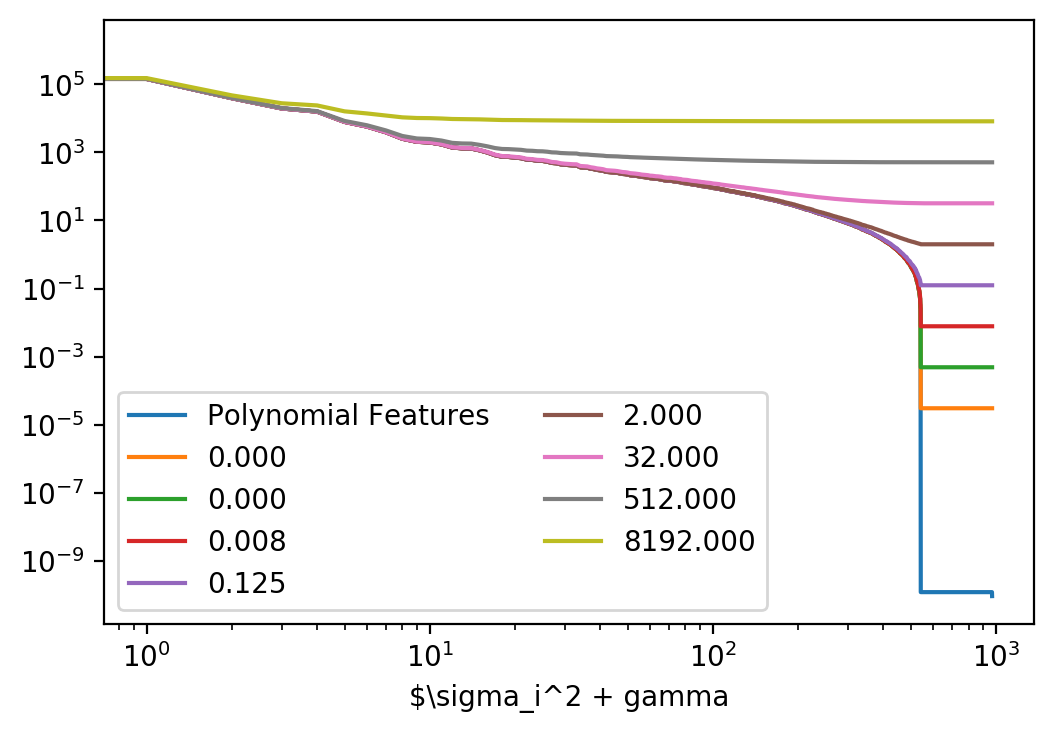

In [189]:
fig,ax = plt.subplots(dpi=200)


ax.plot(range(len(S_poly)), S_poly,label='Polynomial Features')
for i,gi in enumerate(gammas):
    if i%4 == 0:
        ax.plot(range(len(S_poly)), S_poly+gi,label=f'{gi:.3f}')
ax.legend(loc='lower left',ncol=2)
ax.set_xlabel(r'$\sigma_i^2 + gamma')
ax.set_xscale('log')
ax.set_yscale('log')

This plot suggests that $\gamma$ needs to be somewhat substantial to improve the conditioning.

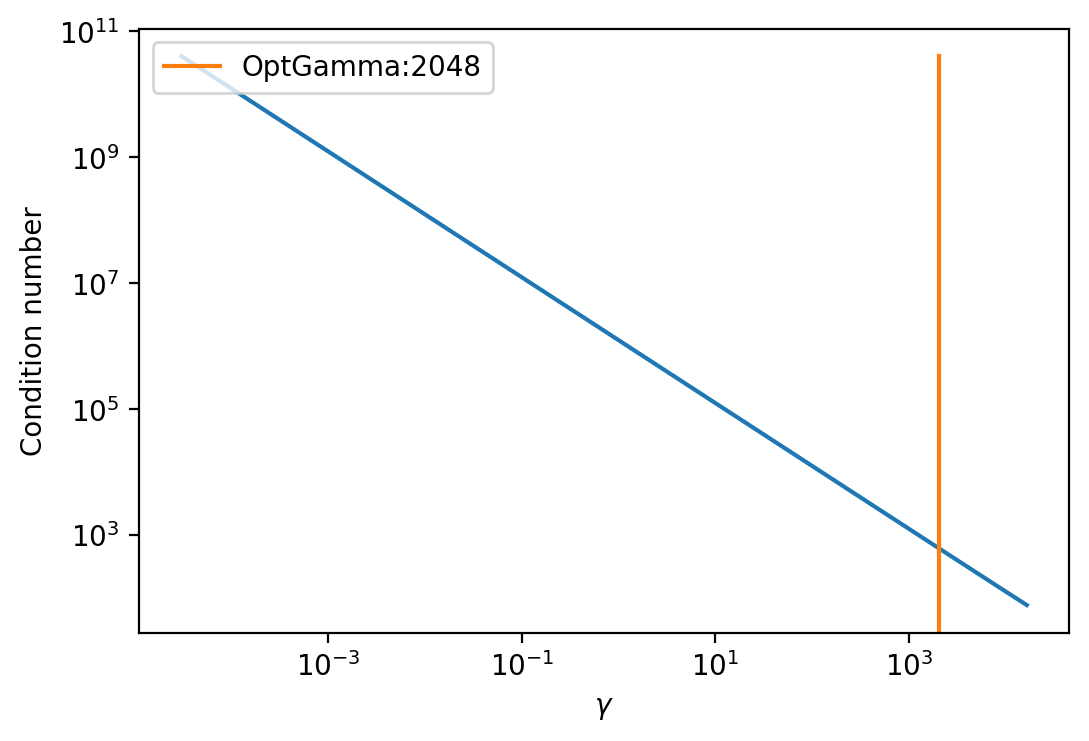

In [190]:
fig,ax = plt.subplots(dpi=200)
conds = np.zeros_like(gammas)
smin,smax = S_poly.min(), S_poly.max()
for i,gi in enumerate(gammas):
    conds[i] = (smax + gi)/(smin + gi)

#ax.plot(range(len(S_lin)), S_lin,label='Raw }Data')
ax.plot(gammas, conds)
ax.plot([opt_gamma,opt_gamma],[0., conds.max()],label=f'OptGamma:{opt_gamma}')
ax.set_ylabel('Condition number')
ax.set_xlabel(r'$\gamma$')
# for i,gi in enumerate(gammas):
#         ax.plot(range(len(S_poly)), S_poly+gi,label=f'{gi:.3f}')
ax.legend(loc='upper left',ncol=2)
ax.set_xscale('log')
ax.set_yscale('log')

### 3.5 Different methods for solving: Quick Comparion
Recall that we have 3 different definitions for obtaining our solution $\hat{x}$.
The last two $ x_W, x_E$ are algebraically equivalent which is easy to show from Woodbury and an SVD.  The first one though, is the exact/brute force solve on the normal equations.  Since $m < d$ this is not going to be scalable for high dimensional problems.

We can briefly elicit this behaviour by performing the following:

In [165]:
%timeit np.linalg.pinv(X_train_poly.T@X_train_poly + 1024.*np.eye(X_train_poly.shape[1]))

442 ms ± 83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [170]:
sketcher = RobustFrequentDirections(X_train_poly.shape[1],m=256)
sketcher.fit(X_train_poly,256)

In [182]:
B = sketcher.sketch
alpha = sketcher.delta
m,d = B.shape
g = 1024.
BATy = B@(X_train_poly.T@y_train)

In [187]:
def woodbury_inv():
    inv_term = np.linalg.pinv(np.eye(m) + B@B.T)
    right_term = inv_term@BATy
    full_inv_term = (1./g)*(X_train_poly.T@y_train) - (B.T/g)@right_term

In [188]:
%timeit woodbury_inv()

14.8 ms ± 195 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


It's clear to see that even on these small test instances, Woodbury is much more scalable and time efficient.